In [1]:
########### Preparation ##############
# import packages
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Import des données
On crée un dataframe Egos qui contient non seulement les informations sur les egos mais aussi leur réseau personnel (egoNet) avec les données des alters.

In [2]:
Egos = pd.read_csv('../data/ego_data.csv', sep = ",")
order_age_cat = ['18-25', '26-30', '31-35','36-40', '41-50', '51-60', '60+']
Egos['ego.age.cat'] = pd.Categorical(Egos['ego.age.cat'], 
                                     categories=order_age_cat, ordered=True)
order_edu_cat = ['Primary', 'Secondary', 'University']
Egos['ego.edu'] = pd.Categorical(Egos['ego.edu'], 
                                     categories=order_edu_cat, ordered=True)
Egos['ego.employed'] = Egos['ego.empl.bin']=="Yes"
Alters = pd.read_csv('../data/alter_attributes.csv', sep = ",")
AltersEdglist = pd.read_table('../data/alter_ties.csv', sep = ",")

def CreatingEgoNet(ego_ID):
    egoNet = nx.from_pandas_edgelist(AltersEdglist[AltersEdglist["ego_ID"]==ego_ID], 'from','to', create_using=nx.Graph())
    nodeData = Alters[Alters["ego_ID"]==ego_ID].set_index('alter_ID').to_dict('index').items()
    egoNet.add_nodes_from(nodeData)
    return egoNet
Egos["egoNet"] = Egos["ego_ID"].apply(CreatingEgoNet)
Egos.set_index("ego_ID", inplace=True)
Egos.sample(5)

,ego.sex,ego.age,ego.arr,ego.edu,ego.inc,empl,ego.empl.bin,ego.age.cat,ego.employed,egoNet
ego_ID,,,,,,,,,,
71,Male,33.0,2010.0,Primary,250.0,1,No,31-35,False,"(7101, 7102, 7103, 7104, 7105, 7106, 7107, 710..."
95,Male,43.0,1997.0,Primary,800.0,4,Yes,41-50,True,"(9501, 9502, 9503, 9504, 9505, 9506, 9507, 950..."
93,Male,47.0,2010.0,Primary,880.0,4,Yes,41-50,True,"(9301, 9302, 9303, 9305, 9306, 9307, 9309, 931..."
121,Male,42.0,2002.0,Secondary,900.0,3,Yes,41-50,True,"(12101, 12102, 12103, 12104, 12105, 12106, 121..."
135,Male,35.0,2009.0,Secondary,300.0,3,Yes,31-35,True,"(13501, 13502, 13503, 13504, 13505, 13506, 135..."


On peut facilement visualiser le réseau de n'importe quel ego de cette façon

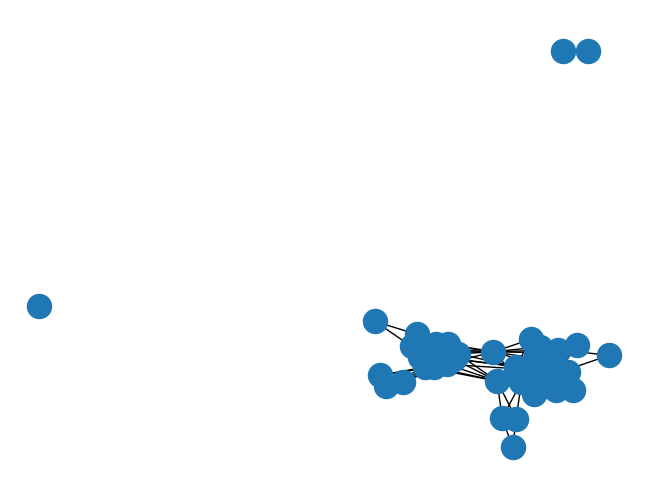

In [3]:
nx.draw(Egos.loc[149,"egoNet"])

# Quelques statistiques structurelles sur les réseaux ego

In [4]:
# ---- Mean local structures
nb_isolates = lambda net: len(list(nx.isolates(net)))
Egos["egoNet.nb_isolates"] = Egos["egoNet"].apply(nb_isolates)
# triads
Egos["egoNet.transitivity"] = Egos["egoNet"].apply(nx.transitivity)

Egos["egoNet.average_clustering"] = Egos["egoNet"].apply(nx.average_clustering)

# ---- Global structures : cohesion
Egos["egoNet.density"] = Egos["egoNet"].apply(nx.density)

# ---- Global structures : connectivity -> not for undirected networks

# ---- Global structures : centrality
mean_degree_centrality = lambda net : np.mean(list(nx.degree_centrality(net).values()))
Egos["egoNet.mean_degree_centrality"] = Egos["egoNet"].apply(mean_degree_centrality)

mean_eigenvector_centrality = lambda net : np.mean(list(nx.eigenvector_centrality(net).values()))
Egos["egoNet.mean_eigenvector_centrality"] = Egos["egoNet"].apply(mean_eigenvector_centrality)

mean_betweenness_centrality = lambda net : np.mean(list(nx.betweenness_centrality(net).values()))
Egos["egoNet.mean_betweenness_centrality"] = Egos["egoNet"].apply(mean_betweenness_centrality)

mean_closeness_centrality = lambda net : np.mean(list(nx.closeness_centrality(net).values()))
Egos["egoNet.mean_closeness_centrality"] = Egos["egoNet"].apply(mean_closeness_centrality)

## Statistiques croisés du réseau Ego avec les variables des Egos

<AxesSubplot: xlabel='ego.years_since_arr', ylabel='egoNet.mean_degree_centrality'>

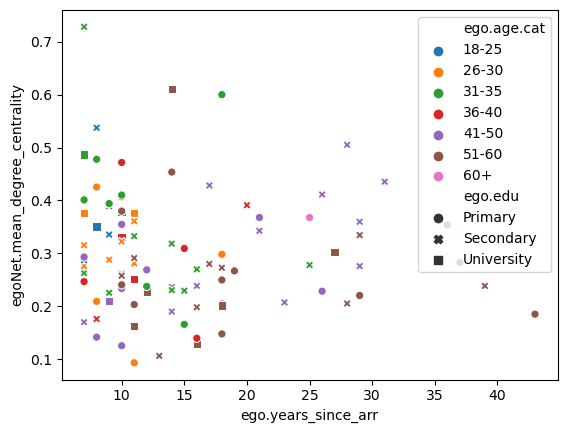

In [5]:
reference_year = 2018 # year of Vacca's publication
Egos["ego.years_since_arr"] = reference_year - Egos["ego.arr"]

sns.scatterplot(data = Egos, x = "ego.years_since_arr", y = "egoNet.mean_degree_centrality", 
                hue= "ego.age.cat",hue_order=order_age_cat,
                style="ego.edu", style_order=order_edu_cat)

<AxesSubplot: xlabel='ego.inc', ylabel='egoNet.mean_degree_centrality'>

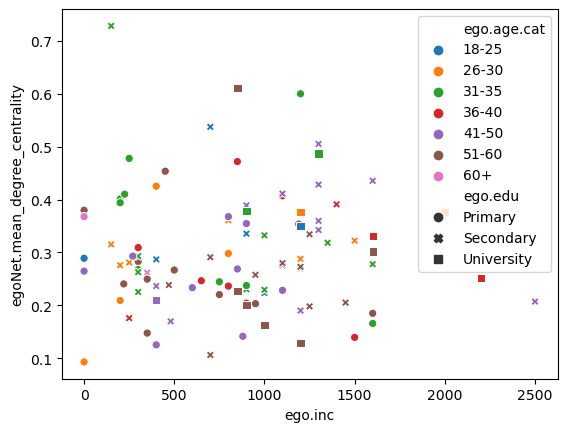

In [6]:
sns.scatterplot(data = Egos, x = "ego.inc", y = "egoNet.mean_degree_centrality", 
                hue= "ego.age.cat",hue_order=order_age_cat,
                style="ego.edu", style_order=order_edu_cat)

<AxesSubplot: xlabel='ego.age.cat', ylabel='egoNet.mean_degree_centrality'>

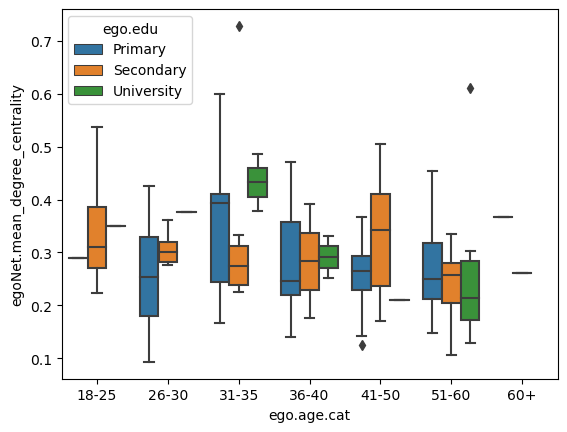

In [7]:
sns.boxplot(data=Egos, x="ego.age.cat", y="egoNet.mean_degree_centrality", hue="ego.edu")

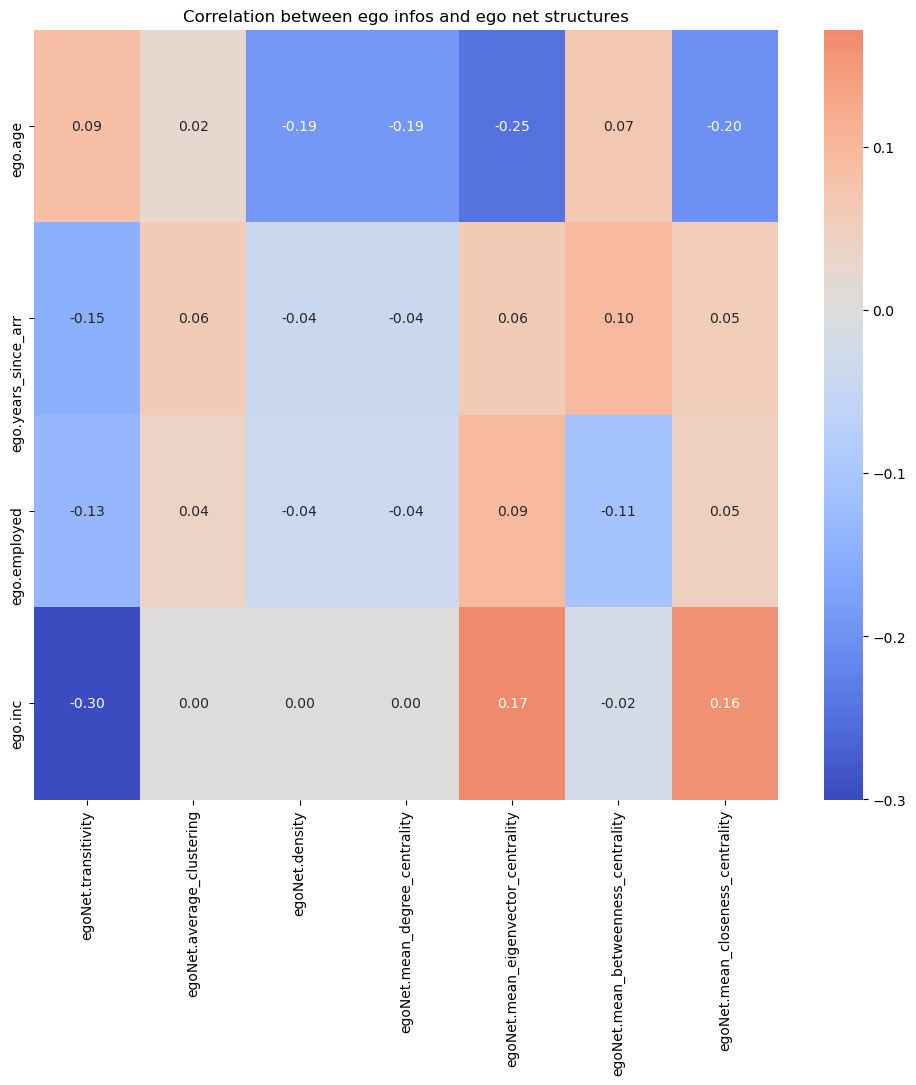

In [8]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is named Egos
# Replace Egos with the name of your dataframe

# Define variables for each group
group1_vars = ['ego.age','ego.years_since_arr','ego.employed', 'ego.inc']
group2_vars = ['egoNet.transitivity', 'egoNet.average_clustering', 'egoNet.density',
               'egoNet.mean_degree_centrality', 'egoNet.mean_eigenvector_centrality',
               'egoNet.mean_betweenness_centrality',
               'egoNet.mean_closeness_centrality']

# Calculate correlation matrix between the two groups
corr = Egos[group1_vars + group2_vars].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(corr.loc[group1_vars, group2_vars], cmap='coolwarm', annot=True, fmt=".2f", center=0)

plt.title('Correlation between ego infos and ego net structures')
plt.show()


# Découpe du Ego Net en sous réseau selon l'origine de l'Alter

## Exemple sur  l'Ego 28 et définitions de fonctions

In [9]:
egoNet28  = Egos.loc[28,"egoNet"]

In [10]:
import networkx as nx

def filter_graph_by_attribute(graph, attribute_name, desired_category, keep_true=True):
    """
    Filter a NetworkX graph based on a categorical attribute and retain node attributes.
    
    Parameters:
        graph (nx.Graph): The original NetworkX graph.
        attribute_name (str): The name of the categorical attribute to filter on.
        desired_category (str): The desired category value.
        keep_true (bool): If True, keep nodes where the attribute matches the desired category.
                          If False, keep nodes where the attribute does not match the desired category.
    
    Returns:
        nx.Graph: The filtered graph.
    """
    filtered_graph = nx.Graph()
    
    try:
        # Add nodes from the original graph based on the value of the categorical attribute
        for n, data in graph.nodes(data=True):
            if (data.get(attribute_name) == desired_category and keep_true) or \
               (data.get(attribute_name) != desired_category and not keep_true):
                filtered_graph.add_node(n, **data)
        
        # Add edges from the original graph involving the filtered nodes
        filtered_graph.add_edges_from(graph.edges(filtered_graph.nodes()))
        
    except Exception as e:
        print("An error occurred while filtering the graph:", e)
    
    return filtered_graph

# Example usage:
# Assuming G is your original graph
# filtered_G = filter_graph_by_attribute(G, 'category_attribute', 'desired_category_value', keep_true=True)


Réseau personnel de l'ego 28 au Sri Lanka

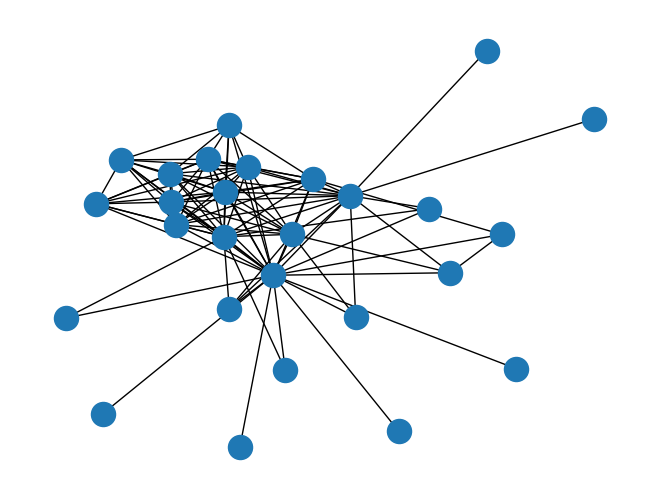

In [11]:
filter_resSL_natSL = lambda net: filter_graph_by_attribute(
    filter_graph_by_attribute(net, 'alter.nat', "Sri Lanka", keep_true=True),
                                  'alter.res', "Sri Lanka", keep_true=True)
nx.draw(filter_resSL_natSL(egoNet28))

Réseau personnel de l'ego 28 de Srilankais habitants hors du Sri Lanka

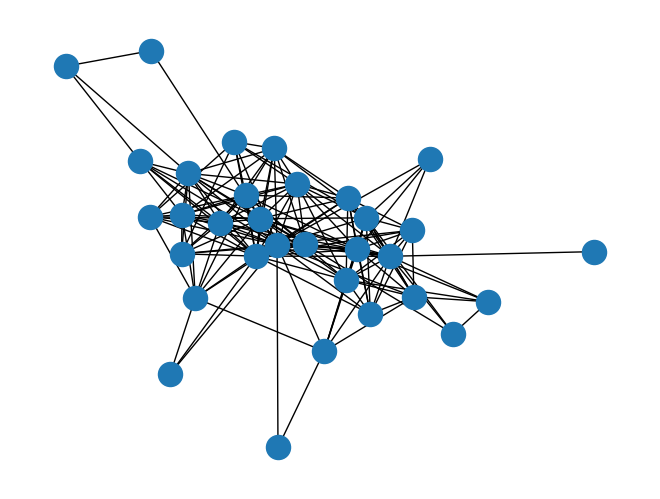

In [12]:
filter_resHorsSL_natSL = lambda net: filter_graph_by_attribute(
    filter_graph_by_attribute(net, 'alter.nat', "Sri Lanka", keep_true=True),
                                  'alter.res', "Sri Lanka", keep_true=False)
nx.draw(filter_resHorsSL_natSL(egoNet28))

Réseau personnel de l'ego 28 de Srilankais habitant en Italie

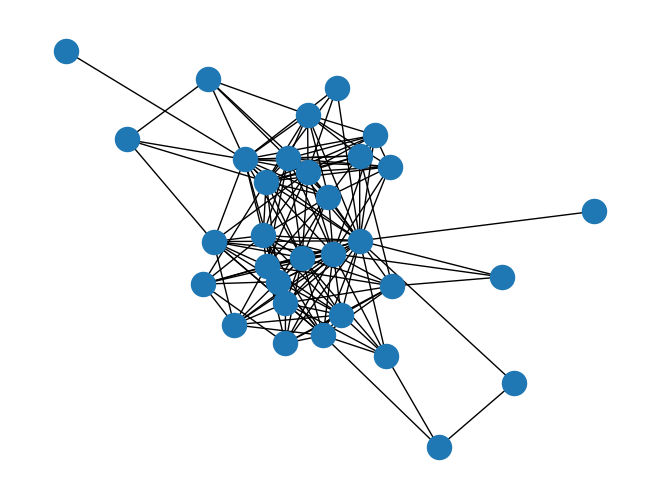

In [13]:
filter_resIT_natSL = lambda net: filter_graph_by_attribute(
    filter_graph_by_attribute(net, 'alter.nat', "Sri Lanka", keep_true=True),
                                  'alter.res', "Italy", keep_true=True)
nx.draw(filter_resIT_natSL(egoNet28))

Réseau personnel de l'ego 28 en Italie non srilankais

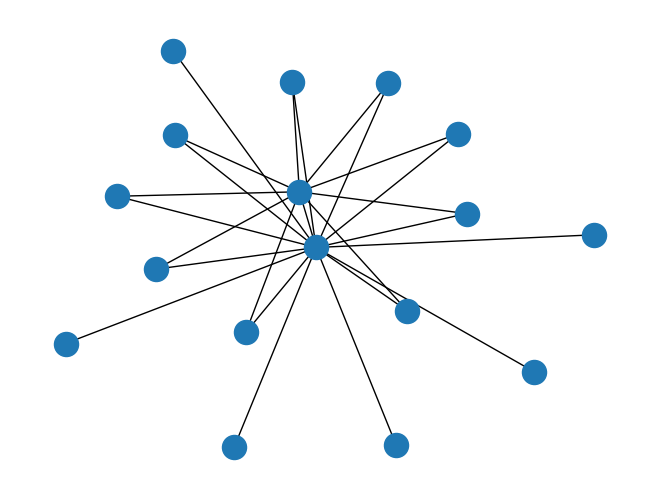

In [14]:
filter_resIT_natNonSL = lambda net: filter_graph_by_attribute(
    filter_graph_by_attribute(net, 'alter.nat', "Sri Lanka", keep_true=False),
                                  'alter.res', "Italy", keep_true=True)
nx.draw(filter_resIT_natNonSL(egoNet28))

Réseau personnel de l'ego 28 de nationalité italienne

In [15]:
filter_natIT = lambda net: filter_graph_by_attribute(net, 
                                'alter.nat', "Italy", keep_true=True)
nx.is_empty(filter_natIT(egoNet28))

True

## Sous réseaux du réseau Ego selon la nationalité et la résidence

In [16]:
Egos['resSLnatSL_egoNet'] = Egos['egoNet'].apply(filter_resSL_natSL)
Egos['resITnatSL_egoNet'] = Egos['egoNet'].apply(filter_resIT_natSL)
Egos['resIT_egoNet'] = Egos['egoNet'].apply(filter_resIT_natNonSL)
Egos['natIT_egoNet'] = Egos['egoNet'].apply(filter_natIT)

## Présence d'un réseau composé d'italiens

In [19]:
Egos['natIT_egoNet.is_empty'] = Egos['natIT_egoNet'].apply(nx.is_empty)

Egos['natIT_egoNet.is_empty'].value_counts()

False    86
True     16
Name: natIT_egoNet.is_empty, dtype: int64

<AxesSubplot: xlabel='natIT_egoNet.is_empty', ylabel='ego.age'>

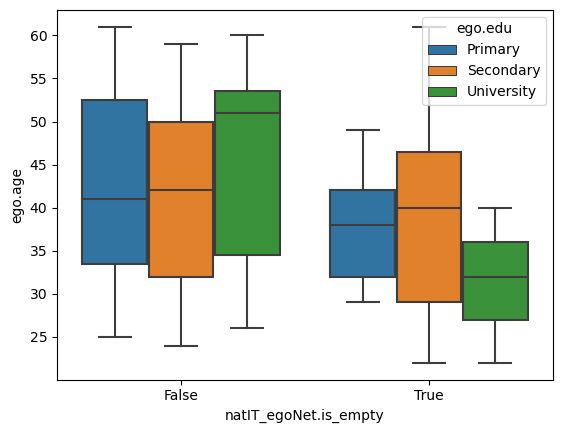

In [21]:
sns.boxplot(data=Egos, x='natIT_egoNet.is_empty', y="ego.age", hue="ego.edu")

<AxesSubplot: xlabel='natIT_egoNet.is_empty', ylabel='ego.years_since_arr'>

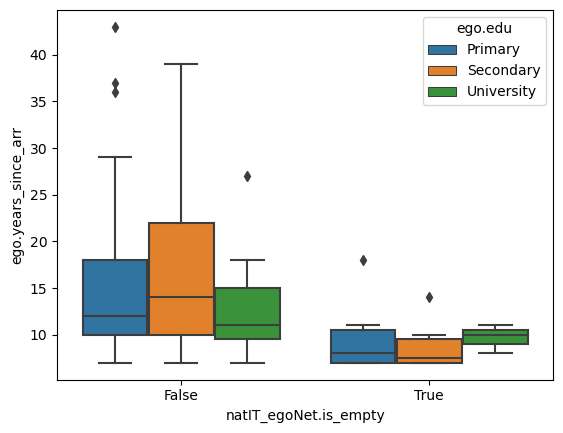

In [23]:
sns.boxplot(data=Egos, x='natIT_egoNet.is_empty', y="ego.years_since_arr", hue="ego.edu")

<AxesSubplot: xlabel='natIT_egoNet.is_empty', ylabel='ego.inc'>

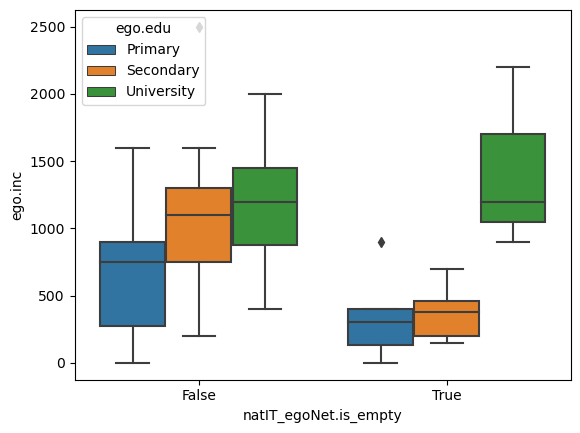

In [25]:
sns.boxplot(data=Egos, x='natIT_egoNet.is_empty', y="ego.inc", hue="ego.edu")

<AxesSubplot: xlabel='natIT_egoNet.is_empty', ylabel='empl'>

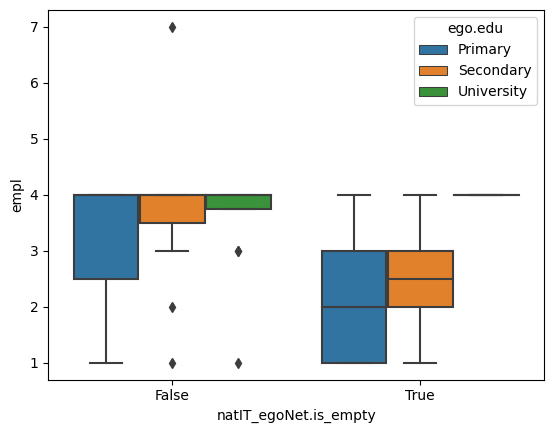

In [26]:
sns.boxplot(data=Egos, x='natIT_egoNet.is_empty', y="empl", hue="ego.edu")